### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 21 is here the size of the considered amino acid alphabet.


---

Jupyterhub keeps losing these packages, so just for setup:

In [1]:
! pip install pyvolve

Defaulting to user installation because normal site-packages is not writeable


In [2]:
! pip install plotly

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import plotly.io as pio
pio.renderers.default = "iframe"

---

In [4]:
# set this to None if "true" randomness is desired, otherwise the runs are reproducible given the same SEED and that the same simulated data is used
SEED = 42

In [5]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import scipy.stats
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

if SEED is not None:
    # enable deterministic tensorflow behaviour (https://github.com/NVIDIA/framework-determinism/blob/master/doc/tensorflow.md)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

import sys
sys.path.insert(0, 'modules/')
import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))
import dataset as dsg
print(importlib.reload(dsg))
import model
print(importlib.reload(model))
import aadist
print(importlib.reload(aadist))
import initProfilesExperiment as ipe
print(importlib.reload(ipe))


#sys.path.insert(0, '../../Software/GeneLinkDraw/')
#sys.path.insert(0, '../../Software/MSAgen/')
sys.path.insert(0, 'modules/GeneLinkDraw/')
sys.path.insert(0, 'modules/MSAgen/')
import geneLinkDraw as gld
print(importlib.reload(gld))
import MSAgen
print(importlib.reload(MSAgen))

print(tf.__version__)

%load_ext memory_profiler

<module 'sequtils' from 'modules/sequtils.py'>
<module 'seq' from 'modules/seq.py'>
<module 'dataset' from 'modules/dataset.py'>
<module 'model' from 'modules/model.py'>
<module 'aadist' from 'modules/aadist.py'>
<module 'initProfilesExperiment' from 'modules/initProfilesExperiment.py'>
<module 'geneLinkDraw' from 'modules/GeneLinkDraw/geneLinkDraw.py'>
<module 'MSAgen' from 'modules/MSAgen/MSAgen.py'>
2.5.0


In [6]:
use_toy_data = False
use_sim_data = True
use_real_data = False
assert use_toy_data or use_sim_data or use_real_data
assert not (use_toy_data and use_sim_data)
assert not (use_toy_data and use_real_data)
assert not (use_sim_data and use_real_data)

### Get Data

#### Create random genomes as toy data 

In [7]:
if use_toy_data:
    N = 8            # number of genomes
    repeatsPerGenome = 10 # number of times to insert repeats into each genome
    multiplyRepeats = 1   # multiply repeat patterns
    # A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
    # Tiles should be about gene-sized.

    #genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
    #insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
    #genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

    genome_sizes = [[10000]] * N
                    # in nucleotides
    insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA"] 
    repeatPatterns = ['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
    genomes, repeatTracking, insertTracking = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                                                                   repeatPatterns,
                                                                   mutationProb=0.0, 
                                                                   repeatMultiple=[multiplyRepeats],#range(1,2),
                                                                   repeatInsert=[repeatsPerGenome],#range(10,11),
                                                                   verbose=(not use_real_data))
    print("insert:", insertTracking)
    print("repeat:", repeatTracking)

In [8]:
if use_toy_data:
    # assert patterns are all inserted
    assert len(insertTracking) == N, str(len(insertTracking))
    for g in insertTracking:
        assert len(insertTracking[g]) == len(genome_sizes[g]), str(len(insertTracking[g]))+", "+str(g)
        for c in insertTracking[g]:
            assert len(insertTracking[g][c]['pos']) == 1
            assert len(insertTracking[g][c]['pattern']) == 1
            pos = insertTracking[g][c]['pos'][0]
            pat = insertTracking[g][c]['pattern'][0]
            k = len(pat)
            assert genomes[g][c][pos:pos+k] == pat

    assert len(repeatTracking) == N, str(len(repeatTracking))
    for g in repeatTracking:
        assert len(repeatTracking[g]) == len(genome_sizes[g]), str(len(repeatTracking[g]))+", "+str(g)
        for c in repeatTracking[g]:
            assert len(repeatTracking[g][c]['pos']) == repeatsPerGenome, str(len(repeatTracking[g][c]['pos']))+", "+str(c)+", "+str(g)
            assert len(repeatTracking[g][c]['pattern']) == repeatsPerGenome, str(len(repeatTracking[g][c]['pattern']))+", "+str(c)+", "+str(g)
            for i in range(repeatsPerGenome):
                pos = repeatTracking[g][c]['pos'][i]
                pat = repeatTracking[g][c]['pattern'][i]
                k = len(pat)
                assert genomes[g][c][pos:pos+k] == pat

In [9]:
if use_toy_data:
    flat_genomes = []
    tracking = {}
    i = 0
    for g in range(len(genomes)):
        for c in range(len(genomes[g])):
            flat_genomes.append(SeqRecord(Seq(genomes[g][c]),
                                          id=str(i), description=""))
            tracking[i] = {'insert': dict(insertTracking[g][c]),
                           'repeat': dict(repeatTracking[g][c])}
            i += 1
            
    with open("artificial.fasta", "w") as output_handle:
        SeqIO.write(flat_genomes, output_handle, "fasta")
        
    with open("tracking.json", "w") as fh:
        json.dump(tracking, fh)

In [10]:
if not use_toy_data:
    insertPatterns = None
    repeatPatterns = None

In [11]:
def printExpectedPatterns():
    desiredPatternAA, repeatPatternAA = None, None
    if insertPatterns is not None:
        desiredPatternAA = []
        for pattern in insertPatterns:
            desiredPatternAA.extend(su.six_frame_translation(pattern))

        print("Desired:", desiredPatternAA)

    if repeatPatterns is not None:
        repeatPatternAA = []
        for pattern in repeatPatterns:
            repeatPatternAA.extend(su.six_frame_translation(pattern))

        print("Repeat:", repeatPatternAA)
        
    return desiredPatternAA, repeatPatternAA

desiredPatternAA, repeatPatternAA = printExpectedPatterns()

#### Create Simulated Data

In [12]:
if use_sim_data:
    N = 8
    seqlen = 110000
    genelen = 140
    if False:
        sequences, posDict = MSAgen.generate_sequences(N, seqlen, genelen, coding_dist=0.05, noncoding_dist=0.1, tree='star', omega=0.4)
        MSAgen.store_sequences(sequences, posDict, "/home/jovyan/brain/genomegraph/learn_specific_profiles/simulated_sequences.fasta")
    else:
        sequences, posDict = MSAgen.load_sequences("/home/jovyan/brain/genomegraph/learn_specific_profiles/simulated_sequences.fasta",
                                                   "/home/jovyan/brain/genomegraph/learn_specific_profiles/simulated_sequences.posdict.json")
        
    genomes = [[str(seq.seq)] for seq in sequences]

#### Load Real Data

In [13]:
# Load Real Data
if use_real_data:    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    seqnames = [[] for _ in range(len(files))]
    datapath = "../data/20210517_flanked/subset"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta'):
                genomes[i].append(str(seq.seq))
                seqnames[i].append(str(seq.id))
                
            assert len(seqnames[i]) == len(set(seqnames[i])), "Duplicates in file "+files[i]
            
    loadRealGenomes() # do not use magic commands here or loadRealGenomes might be called mutliple times!
    
    # load pickled Q to save time
    Qfile = os.path.join(datapath, "backgroundAAFreqs.pkl4")
    if not os.path.isfile(Qfile):
        print("Getting Q")
        %time Q = seq.backGroundAAFreqs(genomes, True)
        with open(Qfile, 'wb') as fh:
            pickle.dump(Q, fh, protocol=4)
            
    else:
        with open(Qfile, 'rb') as fh:
            Q = pickle.load(fh)

In [14]:
if use_real_data:  
    # set Q to Felix' values
    #Q = aadist.getBackgroundDist()
    Q = seq.backGroundAAFreqs(genomes, True)
    #print(Q)

In [15]:
if use_sim_data:
    Q = seq.backGroundAAFreqs(genomes, True)
    #Q = aadist.getBackgroundDist()
    #Q = np.ones(21, dtype=np.float32)/21
    #print(Q)

background freqs:  1759968.0 *
C 0.0314
K 0.0314
E 0.0314
W 0.0157
T 0.0624
G 0.0625
Y 0.0307
A 0.0635
I 0.0461
N 0.0310
V 0.0624
H 0.0311
S 0.0942
D 0.0310
F 0.0313
M 0.0153
R 0.0941
L 0.0941
P 0.0625
Q 0.0314
* 0.0465


In [16]:
if use_toy_data:
    # uniform background distribution appears to be rather better
    Q = np.ones(21, dtype=np.float32)/21
    print(Q)

In [17]:
print(len(genomes), len(genomes[0]), len(genomes[0][0]))

8 1 110000


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

#### Read in the genome

In [18]:
tile_size = 334  # tile size measured in amino acids

In [19]:
genomes[0][0][0:100]

'ACCGATTGGGATTGGTGGTCAGCGACATTCCGTCGTCTTTAGTGTTCCAGCTCGAGATCATGTCCGGCACTGTAACAAGCCATGTGTGCGCGGCGGCTTG'

In [20]:
# disable until something changed here, no need to test every time
if False:
    dsg.testGenerator(genomes, 5, tile_size, 50000)

In [21]:
genome_sizes = [sum([len(s) for s in genome]) for genome in genomes]
batch_size = 1  # number of X to generate per batch
tiles_per_X = 13 # number of tiles per X (-> X.shape[0])
steps_per_epoch = max(1, np.mean(genome_sizes) // (batch_size*tiles_per_X*tile_size*3))
print(genome_sizes, " -> ", steps_per_epoch)

[110000, 110000, 110000, 110000, 110000, 110000, 110000, 110000]  ->  8.0


---

#### Plot Functions

In [22]:
def plotLogo(P, idxarray = None, pScores = None, pLosses = None, max_print=5, ax=None):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(P.shape[2],max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        if ax is None:
            logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        else:
            logo = logomaker.Logo(profile_df, vpad=.1, width=1, ax=ax)
            
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        scoretext = (f" score={pScores[j]:.3f}") if pScores is not None else ""
        losstext = (f" loss={pLosses[j]:.3f}") if pLosses is not None else ""
        logo.ax.set_title(f"Profile {j}" + scoretext + losstext)

In [23]:
# plot the training history as loss and accuracy curves
def plotHistory(history):
    loss = history['loss']
    Rmax = history['Rmax']
    Rmin = history['Rmin']
    Smax = history['Smax']
    Smin = history['Smin']
    epochs = range(1, len(loss) + 1)

    fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
    ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
    ax[0].set_title('Training loss')
    ax[0].legend()

    ax[1].plot(epochs, Rmax, 'bo', label = 'Rmax')
    ax[1].plot(epochs, Rmin, 'b+', label = 'Rmin')
    ax[1].plot(epochs, Smax, 'go', label = 'Smax')
    ax[1].plot(epochs, Smin, 'g+', label = 'Smin')
    ax[1].set_title('Training R and S')
    ax[1].legend();
    
    return fig, ax

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [24]:
U = 200 #1500 #200 # number of profiles to train
k = 11 #20 # length of profiles
s = 3 #6 # shift to both sides
alpha = 1e-6 # loss norm
gamma = 1#0.4  # softmax scale
l2 = 0.1 # L2 reg factor
match_score_factor = 0.7
learning_rate = 2 #0.01 # 1.0
rho = 0 #0.5 # influence of initial sampling position on profile initialization
sigma = 1 #0.1 # stddev of random normal values added to profile initialization (mean 0)
profile_plateau_dev = 0.3

n_best_profiles=3
lossStrategy = 'experiment' #'score' #'experiment' #'softmax'

In [25]:
if use_sim_data:
    print("[DEBUG] >>> setting parameters for simulated data")
    U = 200 #1500 #200 # number of profiles to train
    k = 20 #20 # length of profiles
    s = 0 #6 # shift to both sides
    alpha = 1e-6 # loss norm
    gamma = 1#0.4  # softmax scale
    l2 = 0.01 # L2 reg factor
    match_score_factor = 0.7
    learning_rate = 2 # 0.5
    rho = 0 #0.5 # influence of initial sampling position on profile initialization
    sigma = 1 #0.1 # stddev of random normal values added to profile initialization (mean 0)
    profile_plateau_dev = 150

    n_best_profiles=2
    lossStrategy = 'experiment' #'score' #'experiment' #'softmax'

[DEBUG] >>> setting parameters for simulated data


In [26]:
print(importlib.reload(model))

<module 'model' from 'modules/model.py'>


Number of profiles: 236


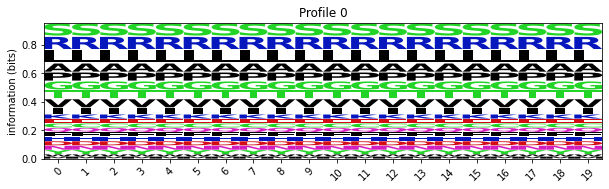

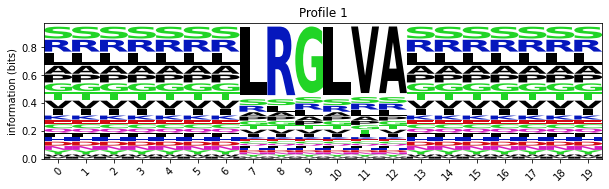

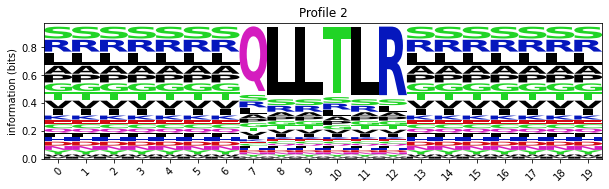

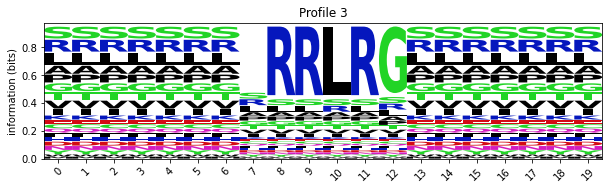

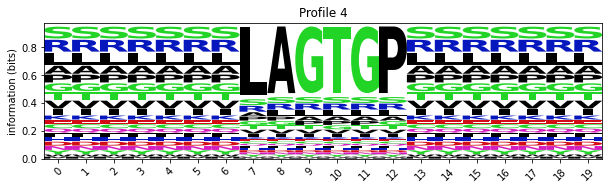

In [27]:
if True:
    midK = 6
    kmerCount = {}
    for g in range(len(genomes)):
        for c in range(len(genomes[g])):
            for seq in su.six_frame_translation(genomes[g][c]):
                for i in range(len(seq)-midK+1):
                    kmer = seq[i:i+midK]
                    if (' ' not in kmer):
                        if kmer not in kmerCount:
                            kmerCount[kmer] = 0

                        kmerCount[kmer] += 1
                        
    midKmers = [kmer for kmer in kmerCount if kmerCount[kmer] >= 8]
    print("Number of profiles:", len(midKmers))
    exhaustiveInitProfiles = ipe.getCustomMidProfiles(midKmers, k+(2*s), Q, mid_factor=0.5, bg_factor=0.5)
    
    #exhaustiveInitProfiles = ipe.getExhaustiveProfiles(k+(2*s), Q,#aadist.getBackgroundDist(), 
    #                                                   mid_factor=0.5, bg_factor=0.5, exp=2)#, mu=1, sigma=1/21)
    
    # add an all-Q profile to the beginning
    allQprofile = np.repeat([np.array(Q, dtype=np.float32)], repeats=k, axis=0) # all-Q profile
    allQprofile = np.expand_dims(allQprofile, 2)
    exhaustiveInitProfiles = np.concatenate([allQprofile, exhaustiveInitProfiles], axis=2)
    
    U = exhaustiveInitProfiles.shape[2]
    plotLogo(tf.constant(exhaustiveInitProfiles))
    
    trackProfiles = [0, 142, 8] # set to None if no tracking desired, otherwise list of profile indices
else:
    exhaustiveInitProfiles = None
    trackProfiles = None

In [28]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
specProModel = None
specProModel = model.SpecificProfile(k, su.aa_alphabet_size, U, Q, 
                                     alpha=alpha, gamma=gamma, l2=l2, 
                                     shift=s, loss=lossStrategy, P_logit_init=exhaustiveInitProfiles, 
                                     track_profiles=trackProfiles, rand_seed=SEED)

[DEBUG] >>> setting tf global seed to 42
[DEBUG] >>> using softmaxLoss: False // using experimentLoss: True
[DEBUG] >>> Using P_logit_init from arguments instead of random


### Training Set

In [29]:
if exhaustiveInitProfiles is None:
    %time P_logit_init = specProModel.seed_P_genome(genomes, rho=rho, sigma=sigma)
    specProModel.setP_logit(P_logit_init)

### Training

In [30]:
trainingWithReporting = True

In [31]:
dsh = dsg.DatasetHelper(genomes, tiles_per_X, tile_size, batch_size, 3)

toy_data:

    print(np.mean(bestlosshist[340:350]))
    print(np.std(bestlosshist[340:350]))
    print([v-np.mean(bestlosshist[340:350]) for v in bestlosshist[340:350]])

    -156128.95
    0.21841492
    [0.390625, 0.3125, 0.140625, 0.09375, 0.015625, -0.078125, -0.109375, -0.140625, -0.25, -0.3125]


sim_data: best loss plateau should be fine to use 1/1000 * mean as a threshold

In [32]:
start = time()
if trainingWithReporting:
    specProModel.train_reporting(genomes, dsh, steps_per_epoch, epochs=350, 
                                 learning_rate=learning_rate, profile_plateau=10, profile_plateau_dev=profile_plateau_dev,
                                 verbose_freq=10, n_best_profiles=n_best_profiles, match_score_factor=match_score_factor)
else:
    ds = dsh.getDataset(repeat=True)
    specProModel.train_classic(ds, steps_per_epoch, epochs=350, learning_rate=learning_rate)
    
end = time()
print(f"time: {end-start:.2f}")

[DEBUG] >>> nan in P: Tensor("cond/Any:0", shape=(237,), dtype=bool) Tensor("cond/boolean_mask/GatherV2:0", shape=(20, 21, None), dtype=float32)
[DEBUG] >>> Q: [0.0313875  0.0314483  0.03140455 0.01572472 0.06239829 0.06249602
 0.03068578 0.06347048 0.04610936 0.03097329 0.06239545 0.03105681
 0.09421251 0.03104829 0.03133239 0.01525937 0.09414546 0.09408637
 0.06249602 0.03135853 0.04651051]
[DEBUG] >>> nan in R
[DEBUG] >>> nan in X
[DEBUG] >>> nan in Z
[DEBUG] >>> nan in P: Tensor("cond/Any:0", shape=(237,), dtype=bool) Tensor("cond/boolean_mask/GatherV2:0", shape=(20, 21, None), dtype=float32)
[DEBUG] >>> Q: [0.0313875  0.0314483  0.03140455 0.01572472 0.06239829 0.06249602
 0.03068578 0.06347048 0.04610936 0.03097329 0.06239545 0.03105681
 0.09421251 0.03104829 0.03133239 0.01525937 0.09414546 0.09408637
 0.06249602 0.03135853 0.04651051]
[DEBUG] >>> nan in R
[DEBUG] >>> nan in X
[DEBUG] >>> nan in Z
epoch 0 best profile 144 with mean loss -14762.114
epoch     0 profile loss sum = 

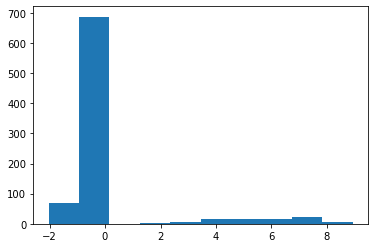

In [33]:
if len(specProModel.P_report):
    plt.hist(tf.reshape(specProModel.getP_report_raw(), (-1)).numpy())
else:
    plt.hist(tf.reshape(specProModel.P_logit, (-1)).numpy())

In [34]:
specProModel.P_report_plosshist.shape

TensorShape([107, 237])

(array([1493., 4596., 7004., 5135., 5278., 1045.,  363.,  257.,  161.,
          27.]),
 array([-31182.75   , -24931.535  , -18680.32   , -12429.1045 ,
         -6177.889  ,     73.32617,   6324.5415 ,  12575.757  ,
         18826.973  ,  25078.188  ,  31329.402  ], dtype=float32),
 <BarContainer object of 10 artists>)

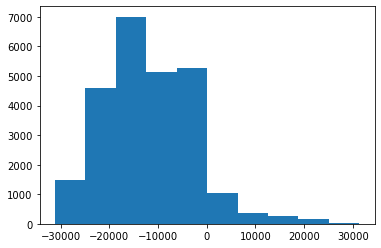

In [35]:
plt.hist(tf.reshape(specProModel.P_report_plosshist, (-1)).numpy())

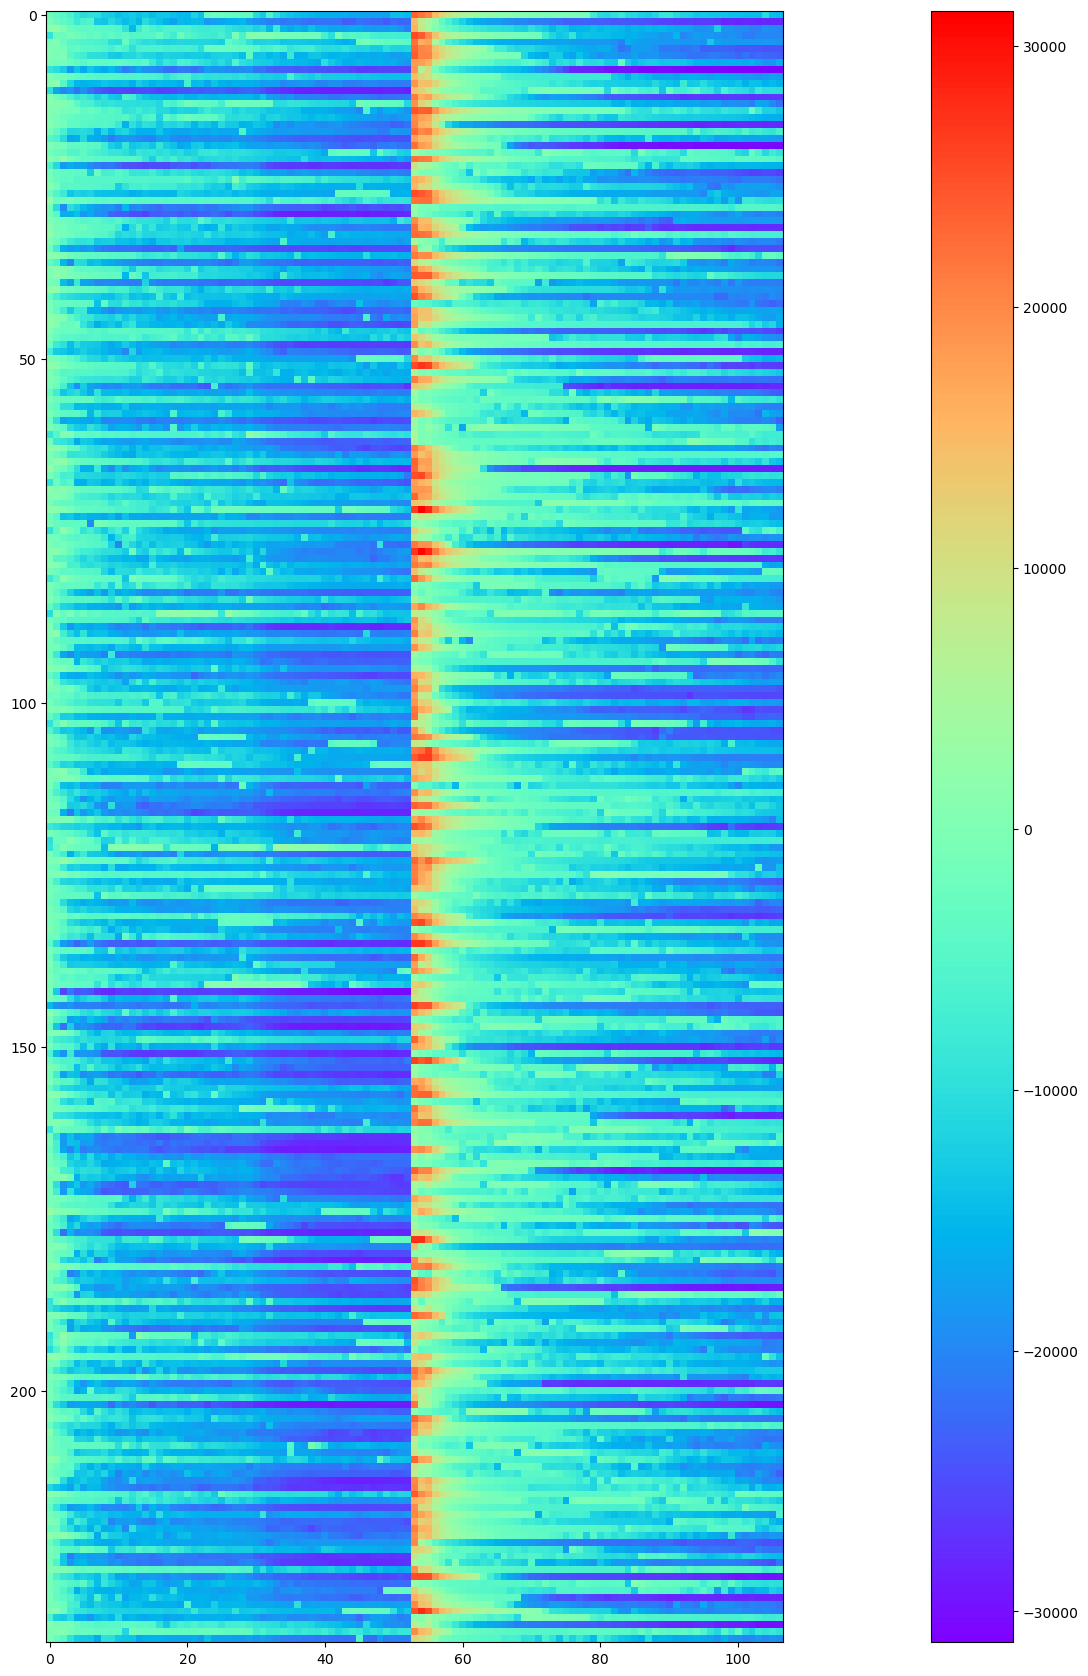

In [36]:
plh = tf.transpose(specProModel.P_report_plosshist).numpy()
#plh = plh + np.min(plh)
#plhm = np.max(plh)
#plh = plh * 255
#plh = plh / plhm

fig, ax = plt.subplots(1,1, figsize=(2*1920/100,2*1080/100), dpi=100)
hm = ax.imshow(plh, interpolation = 'nearest', cmap="rainbow")
plt.colorbar(hm)
fig.show()

In [37]:
bestlosshist = [l.numpy() for l in specProModel.P_report_bestlosshist]
bestlosshistIdx = [i.numpy() for i in specProModel.P_report_bestlosshistIdx]

In [38]:
import plotly.express as px

px.scatter(x = list(range(len(bestlosshist))),
           y = bestlosshist, 
           color = bestlosshistIdx)

In [39]:
c = 0
bincol = [c]
for i in range(1,len(bestlosshistIdx)):
    if bestlosshistIdx[i] != bestlosshistIdx[i-1]:
        c += 1
        
    bincol.append(c)

bincol = [c%2 for c in bincol]

px.scatter(x = list(range(len(bestlosshist))),
           y = bestlosshist, 
           color=bincol)

-12435.421
8021.684
[-17858.043, 9774.919, 7488.492, 7394.125, 5492.247, 2316.5293, -448.93457, -2175.7627, -4260.425, -7723.1494]


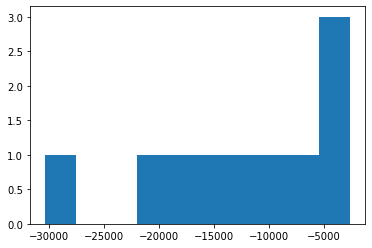

In [40]:
blhwindow = bestlosshist[52:62]
plt.hist(blhwindow)
print(np.mean(blhwindow))
print(np.std(blhwindow))
print([v-np.mean(blhwindow) for v in blhwindow])

In [41]:
#tf.reduce_sum(tf.math.square(specProModel.P_logit), axis=[0,1]) / specProModel.P_logit.shape[0] * l2

In [42]:
#tf.reduce_sum(specProModel.P_logit, axis=[0,1]) #* 0.001

In [43]:
#specProModel.P_logit[:,:,0]
specProModel.getP_report_raw()[:,:,1]

<tf.Tensor: shape=(20, 21), dtype=float32, numpy=
array([[-0.2804146 , -0.25019863, -0.31664485, -0.24915063, -0.2529878 ,
         5.668315  , -0.6845644 , -0.27926642, -0.43148193,  8.750512  ,
        -0.2843086 , -0.26010743,  7.3583384 , -0.34438506, -0.84547085,
        -0.22513668, -0.38202587, -0.25719535, -0.3099479 , -0.28055787,
        -0.2800129 ],
       [-0.72125083, -0.72430706, -1.6162543 , -0.72456396, -0.72450376,
        -0.7240052 ,  5.9288726 , -0.7238002 , -0.99294204, -0.7152828 ,
        -1.2226617 ,  4.3489122 , -0.72346747,  6.1810136 , -0.79269147,
        -0.72422856, -0.72398233, -0.7091147 , -0.7246297 , -0.69425267,
         4.33965   ],
       [-0.07315716, -0.09891225, -0.07464032, -0.09870654, -0.04187062,
        -0.04445449, -0.09910081, -0.09930636, -0.13798669, -0.09917772,
        -0.04872761,  8.935395  , -0.09929559, -0.09900005, -0.0984142 ,
        -0.46241784, -0.09946951, -0.09932148, -0.09905782, -0.09904931,
        -0.05668098],
       [

(<Figure size 1080x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Training loss'}>,
        <AxesSubplot:title={'center':'Training R and S'}>], dtype=object))

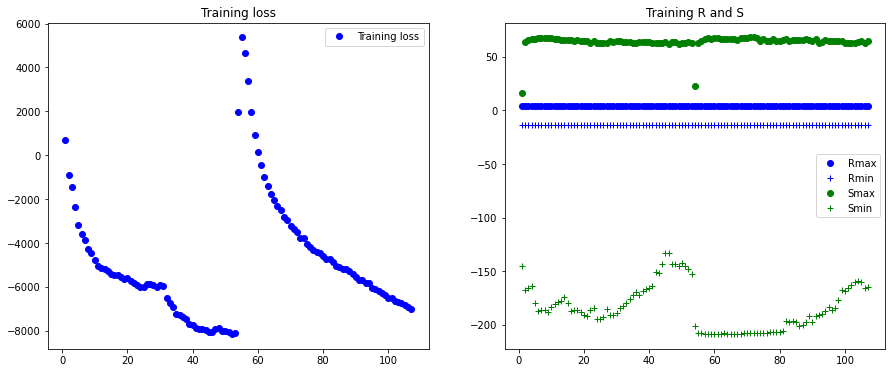

In [44]:
#if trainingWithReporting:
plotHistory(specProModel.history)

In [45]:
for key in specProModel.history:
    print(key, "-- type:", type(specProModel.history[key]), "-- elem type:", type(specProModel.history[key][0]))

loss -- type: <class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> -- elem type: <class 'numpy.float32'>
Rmax -- type: <class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> -- elem type: <class 'numpy.float32'>
Rmin -- type: <class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> -- elem type: <class 'numpy.float32'>
Smax -- type: <class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> -- elem type: <class 'numpy.float32'>
Smin -- type: <class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> -- elem type: <class 'numpy.float32'>
learning rate -- type: <class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> -- elem type: <class 'int'>


### Visualize resulting profiles as sequence logos

In [46]:
if len(specProModel.P_report_discarded) > 0:
    Pedge = tf.nn.softmax(tf.transpose(specProModel.P_report_discarded, [1,2,0]), axis=1)
    print("Edge cases:")
    plotLogo(Pedge)

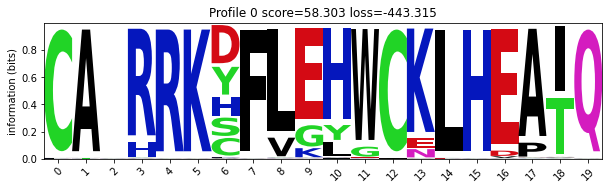

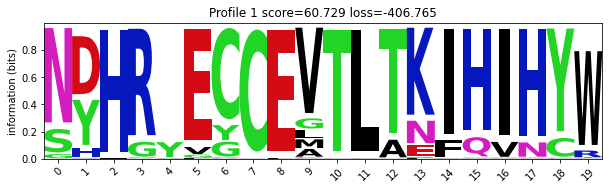

In [47]:
if trainingWithReporting:
    printExpectedPatterns()
    P, Pthresh, Ploss = specProModel.getP_report()
    Pwhole, PwholeScore, PwholeLoss = specProModel.getP_report_whole()
    plotLogo(P=P, pScores=np.array(Pthresh)/match_score_factor, pLosses=Ploss, max_print=10)#, label="Score Threshold")
    #plotLogo(P=Pwhole, pScores=PwholeScore, pLosses=PwholeLoss, max_print=10)#, label="Score Threshold")
    
else:
    ds_score = dsg.getDataset(genomes, tiles_per_X, tile_size).batch(batch_size).prefetch(3)
    printExpectedPatterns()
    P = specProModel.getP()
    pScores = specProModel.max_profile_scores(ds_score)
    #plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=20)
    pLosses = specProModel.min_profile_losses(ds_score)
    # sort after loss
    plotLogo(P=P, idxarray = np.argsort(pLosses), pScores=pScores, pLosses=pLosses, max_print=5)#, label="loss")
    # sort after scores
    #plotLogo(P=P, idxarray = np.argsort(pScores)[::-1], pScores=pScores, pLosses=pLosses, max_print=5)#, label="loss")

In [48]:
if trainingWithReporting:
    for i in range(len(specProModel.P_report)):
        print("profile", i, "-- nsites:", len(specProModel.P_report_masked_sites[i]), "// nlinks:", specProModel.P_report_nlinks[i].numpy())

profile 0 -- nsites: 8 // nlinks: 1
profile 1 -- nsites: 7 // nlinks: 1


In [49]:
if trainingWithReporting and False:
    for s in specProModel.P_report_masked_sites[0]:
        print(s[0])
        g = s[1].numpy()
        c = s[2].numpy()
        a = s[3].numpy()
        b = s[4].numpy()
        print(genomes[g][c][a-5:b+5])

In [50]:
import plotly.express as px

if not trainingWithReporting:
    fig = px.histogram(x=pLosses)
    fig.show()

    print(scipy.stats.describe(pLosses))
    print("mean:", np.mean(pLosses))
    print("std: ", np.std(pLosses))
    print("-Z: ", np.mean(pLosses)-np.std(pLosses))
    print("-2Z:", np.mean(pLosses)-2*np.std(pLosses))

In [51]:
if trainingWithReporting:
    for i in range(len(specProModel.P_report)):
        print("profile", i, "-- kmer scores:", specProModel.P_report_kmer_scores[i])
        
else:
    printExpectedPatterns()
    z = np.mean(pLosses)-np.std(pLosses) # more or less reasonable loss cutoff
    P, scores, losses = specProModel.getP_optimal(dsh, z)
    plotLogo(P=P, idxarray = np.argsort(losses), pScores=scores, pLosses=losses, max_print=5)#, label="loss")

profile 0 -- kmer scores: tf.Tensor([58.302887], shape=(1,), dtype=float32)
profile 1 -- kmer scores: tf.Tensor([60.729187], shape=(1,), dtype=float32)


In [52]:
#if not trainingWithReporting:
#    printExpectedPatterns()
#    plotLogo(P=P, idxarray = np.argsort(-scores), pScores=scores, pLosses=losses, max_print=5)#, label="loss")

In [53]:
#assert False # stop if run all cells

### Get Sensitivity and Specificity

In [54]:
midK = 6
kmerCount = {}
for g in range(len(genomes)):
    for c in range(len(genomes[g])):
        for seq in su.six_frame_translation(genomes[g][c]):
            for i in range(len(seq)-midK+1):
                kmer = seq[i:i+midK]
                if (' ' not in kmer):
                    if kmer not in kmerCount:
                        kmerCount[kmer] = 0

                    kmerCount[kmer] += 1

In [55]:
len(kmerCount)

1392269

In [56]:
maxbin = max([kmerCount[i] for i in kmerCount])
maxbin

14

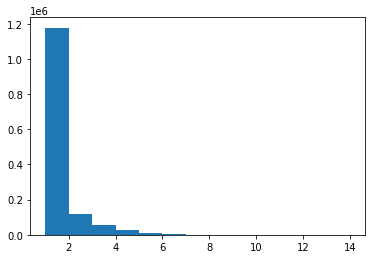

In [57]:
n, bins, _ = plt.hist(x = [kmerCount[i] for i in kmerCount], #if kmerCount[i] >= len(genomes)], 
                      bins = list(range(1, maxbin+1)))

In [58]:
len(n)

13

In [59]:
print("Cumulative number of profiles when kmer occurs >= bin times")
[(str(bins[i])+"-"+str(bins[i+1]), sum(n[i:])) for i in range(len(n))]

Cumulative number of profiles when kmer occurs >= bin times


[('1-2', 1392269.0),
 ('2-3', 213982.0),
 ('3-4', 94805.0),
 ('4-5', 39692.0),
 ('5-6', 12485.0),
 ('6-7', 3108.0),
 ('7-8', 748.0),
 ('8-9', 236.0),
 ('9-10', 67.0),
 ('10-11', 16.0),
 ('11-12', 6.0),
 ('12-13', 2.0),
 ('13-14', 1.0)]

In [60]:
def makeP(count, kmerCount=kmerCount, specProModel=specProModel, geq=False):
    if geq:
        kmers = [kmer for kmer in kmerCount if kmerCount[kmer] >= count]
    else:
        kmers = [kmer for kmer in kmerCount if kmerCount[kmer] == count]
        
    P = np.array([dsg.oneHot(kmer) for kmer in kmers]) # U, k, 21
    P = np.transpose(P, (1,2,0))
    R = specProModel.getR(P).numpy() # (k, 21, U)
    thresh = np.sum(np.multiply(P, R), axis=(0,1), dtype=np.float32) # U, P acts as "sequence", thus calculating the match score of a perfect kmer match in the sequence
    if not geq:
        print("[INFO] >>> Expected number of sites:", count, "*", P.shape[2], "=", count*P.shape[2])
    else:
        print("[INFO] >>> Expected number of sites:", sum([kmerCount[kmer] for kmer in kmerCount if kmerCount[kmer] >= count]))
        
    return P, thresh

In [61]:
if False:
    P, Pthresh = makeP(12, geq=True)
    print(P.shape)

In [62]:
if trainingWithReporting:
    for g in range(len(dsh.genomes)):
        for c in range(len(dsh.genomes[g])):
            dsh.genomes[g][c] = dsh.genomes[g][c].upper()

# get match sites of profiles
thresh = Pthresh if trainingWithReporting else 0.9*scores #match_score_factor*scores

onlyPid = None
if onlyPid is None:
    sites, siteScores, _ = specProModel.get_profile_match_sites(dsh.getDataset(withPosTracking = True), thresh, otherP = P)
else:
    sites, siteScores, _ = specProModel.get_profile_match_sites(dsh.getDataset(withPosTracking = True), thresh[onlyPid], otherP = P[:,:,onlyPid:onlyPid+1])
    
print(sites) # (sites, (genomeID, contigID, pos, u, f))
#print(siteScores)

tf.Tensor(
[[    0     0 15613     1     1]
 [    2     0 15613     1     1]
 [    3     0 15613     1     1]
 [    4     0 15613     1     1]
 [    5     0 15613     1     1]
 [    6     0 15613     1     1]
 [    7     0 15613     1     1]
 [    0     0 39644     0     2]
 [    1     0 39644     0     2]
 [    2     0 39644     0     2]
 [    3     0 39644     0     2]
 [    4     0 39644     0     2]
 [    5     0 39644     0     2]
 [    6     0 39644     0     2]
 [    7     0 39644     0     2]], shape=(15, 5), dtype=int32)


In [63]:
import itertools

def sitesToLinks(sites, linkThreshold = 100):
    # sites.shape == (fwdSites, (genomeID, contigID, pos, u, f))
    links = []
    skipped = []
    profileToOcc = {}
    linkProfiles = set()
    for g, c, p, u, f in sites:
        if u not in profileToOcc:
            profileToOcc[u] = {}
            
        if g not in profileToOcc[u]:
            profileToOcc[u][g] = []
            
        profileToOcc[u][g].append([g,c,p])
        
    for p in profileToOcc:
        if (len(profileToOcc[p].keys()) == 1): # or (0 not in profileToOcc[p]):
            continue
            
        occs = []
        for g in profileToOcc[p]:
            occs.append(profileToOcc[p][g])
            
        nlinks = np.prod([len(og) for og in occs])
        if nlinks > linkThreshold:
            print("[DEBUG] >>> Profile", p, "would produce", nlinks, "links, skipping")
            skipped.append((p, nlinks))
        else:
            l = list(itertools.product(*occs))
            #print("[DEBUG] >>> len(l):", len(l))
            #print("[DEBUG] >>>      l:", l)
            links.extend(l)
            linkProfiles.add((p, nlinks, str(occs)))

    return links, linkProfiles, skipped

links, linkProfiles, skipped = sitesToLinks(sites.numpy(), 1000)
print(links[:5])
print(len(links))
#print(linkProfiles)
#print(skipped)

[([0, 0, 15613], [2, 0, 15613], [3, 0, 15613], [4, 0, 15613], [5, 0, 15613], [6, 0, 15613], [7, 0, 15613]), ([0, 0, 39644], [1, 0, 39644], [2, 0, 39644], [3, 0, 39644], [4, 0, 39644], [5, 0, 39644], [6, 0, 39644], [7, 0, 39644])]
2


In [64]:
links = [sorted(l) for l in links]

In [65]:
if len(skipped):
    fig = px.histogram(x=[s[1] for s in skipped])
    fig.show()

In [66]:
print(len(genomes))
print([len(s) for s in genomes])

8
[1, 1, 1, 1, 1, 1, 1, 1]


### Draw Link Image

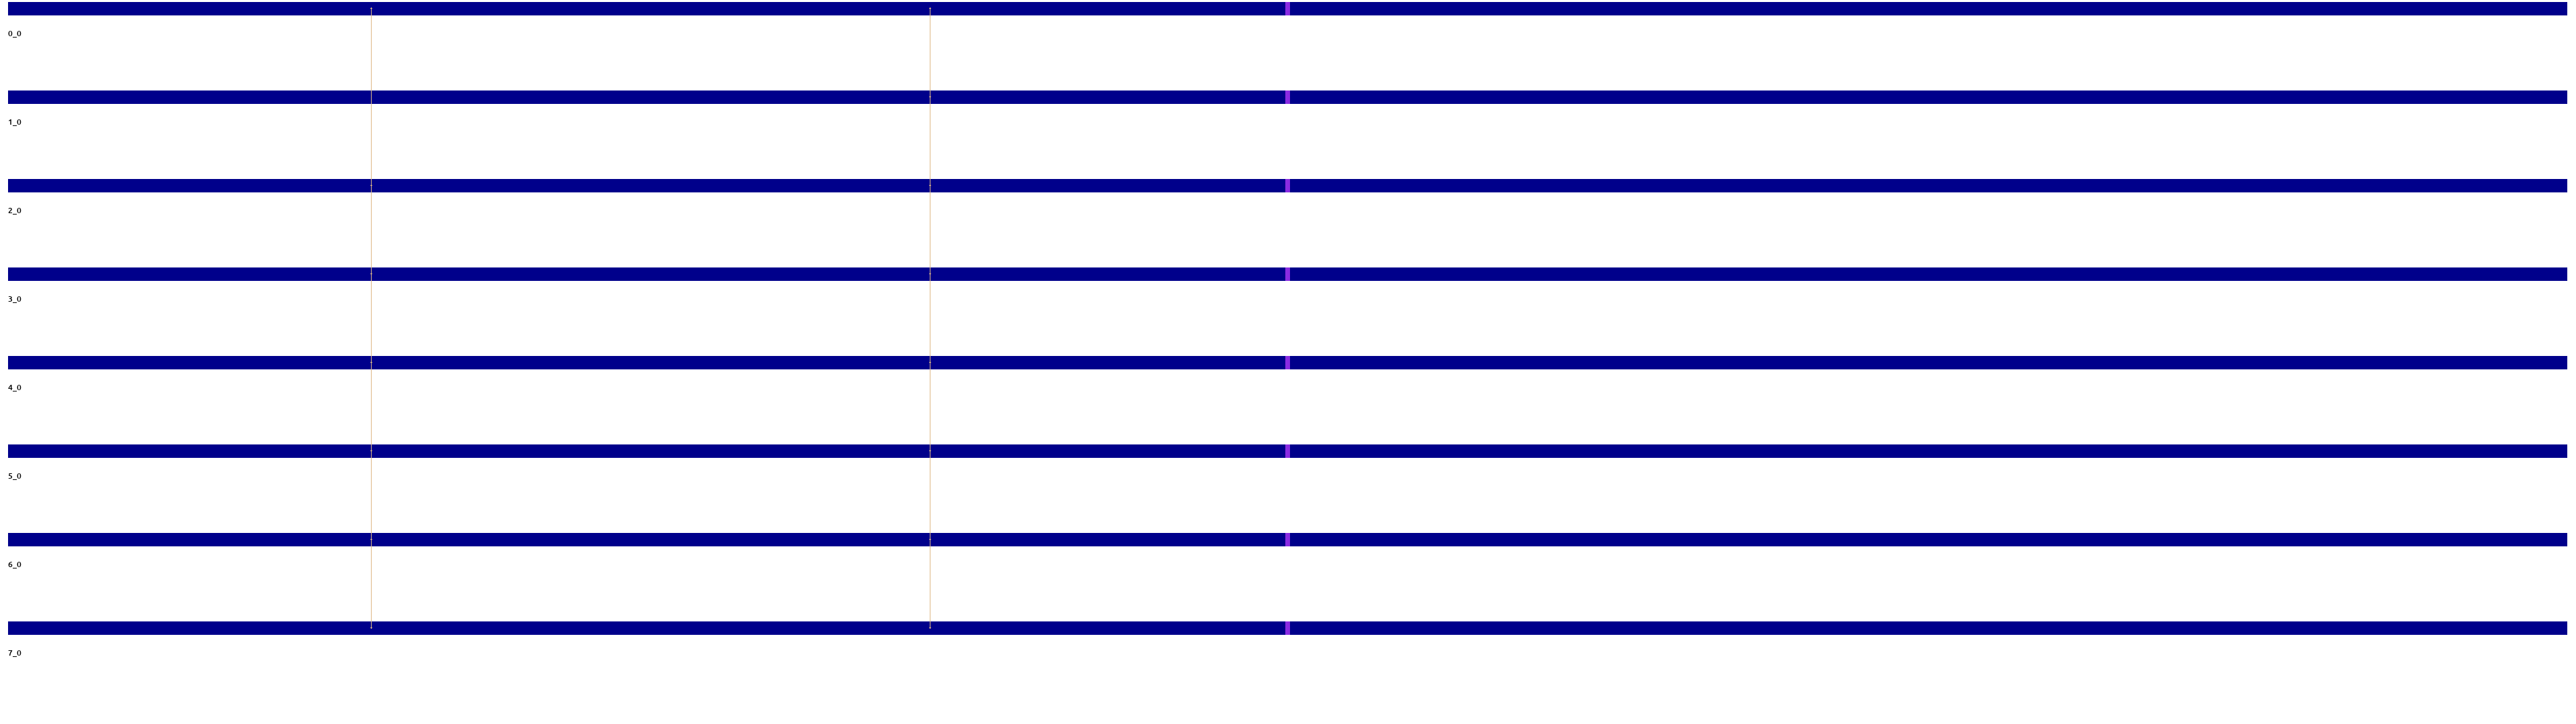

In [67]:
drawGeneLinks = True
if drawGeneLinks and use_sim_data:
    drawGenes = []
    for g in range(len(genomes)):
        for c in range(len(genomes[g])):
            dg = gld.Gene(str(g)+"_"+str(c), str(g), len(genomes[g][c]), "+")
            drawGenes.append(dg)
                    
    for dgene in drawGenes:
        dgene.addElement("gene", posDict['start_codon'], posDict['stop_codon']+2)
        
    # create links to draw
    drawLinks = []
    for link in links:
        lgenes = []
        lpos = []
        for occ in link:
            gid = str(occ[0])+"_"+str(occ[1])
            lgenes.append(gid)
            lpos.append(occ[2])
            
        drawLinks.append(gld.Link(lgenes, lpos))
        
    img, geneToCoord = gld.draw(drawGenes, drawLinks, font = "/opt/conda/fonts/Ubuntu-M.ttf",
                                genewidth = 20, linkwidth = 1, width = (1920*2))
    img.save("links.png")
                    
                    
    
if drawGeneLinks and use_real_data:
    with open(os.path.join(datapath, "orthologs.json"), 'rt') as fh:
        orthology = json.load(fh)
        
    with open(os.path.join(datapath, "hg38.GTF.json"), 'rt') as fh:
        gtf = json.load(fh)
        
    def parseSequenceHeader(header):
        fields = header.split("|")
        headDict = {}
        for field in fields:
            key, value = field.split(":")
            assert len(field.split(":")) == 2, "[ERROR] >>> could not parse header: "+header
            assert key not in headDict, "[ERROR] >>> could not parse header: "+header
            headDict[key] = value

        return headDict

    geneColors = {}
    palette = gld.Palette()
    # first, color all orthologs the same
    for i in range(len(seqnames)):
        for sid in seqnames[i]:
            if sid in orthology and sid not in geneColors:
                geneColors[sid] = palette.color()
                for seq in orthology[sid]:
                    assert seq not in geneColors, str(seq)
                    geneColors[seq] = palette.color()
                    
                palette.inc()
                
    # color all artificials the same
    for i in range(len(seqnames)):
        for sid in seqnames[i]:
            if sid not in geneColors and parseSequenceHeader(sid)['gid'] == 'artificial':
                geneColors[sid] = palette.color()
                
    palette.inc()
    
    # color any remaining sequences
    for i in range(len(seqnames)):
        for sid in seqnames[i]:
            if sid not in geneColors:
                geneColors[sid] = palette.color()
    
    palette.inc()
    
    # create gene and color lists for later drawing
    # first, sort seqnames: first the real sequences, then the artificials, 
    #   such that ortholog sequences have the same index in all genomes
    genomeOrder = []
    for seqs in seqnames:
        genomeOrder.append(parseSequenceHeader(seqs[0])['genome'])
        
    sortedSeqnames = [[] for _ in seqnames]
    for sid in seqnames[0]: # based on reference (i.e. first genome)
        head = parseSequenceHeader(sid)
        if head['gid'] != 'artificial':
            sortedSeqnames[0].append(sid)
            for o in orthology[sid]:
                ohead = parseSequenceHeader(o)
                idx = genomeOrder.index(ohead['genome'])
                sortedSeqnames[idx].append(o)
                
    for i in range(len(seqnames)):
        for sid in seqnames[i]:
            head = parseSequenceHeader(sid)
            if head['gid'] == 'artificial':
                sortedSeqnames[i].append(sid)
                
    # assert that all sequence names are kept
    for i in range(len(seqnames)):
        assert sorted(seqnames[i]) == sorted(sortedSeqnames[i]), "Something went wrong in genome "+str(i)
            
    
    drawGenes = []
    drawGeneColors = []
    for i in range(len(sortedSeqnames)):
        for sid in sortedSeqnames[i]:
            head = parseSequenceHeader(sid)
            dg = gld.Gene(head['genome']+"_"+head['tid'], head['genome'], int(head['seqlen']), head['strand'])
            dg._tid = head['tid'] # add a special field containing just the tid for element addition
            drawGenes.append(dg)
            drawGeneColors.append(geneColors[sid])
            
    # assert no duplicate geneIDs
    geneIDs = [dg.id for dg in drawGenes]
    assert len(geneIDs) == len(set(geneIDs)), "geneIDs contain duplicates"
            
    # add CDS etc.
    for dgene in drawGenes:
        if getattr(dgene, '_tid', None) in gtf:
            elems = gtf[dgene._tid]
            for elem in elems:
                if elem['feature'] == "CDS":
                    dgene.addElement(elem['feature'], elem['rstart'], elem['rend'])

    # create links to draw
    tidToDrawgenes = {}
    for dgene in drawGenes:
        tidToDrawgenes[dgene.id] = dgene
        
    drawLinks = []
    for link in links:
        lgenes = []
        lpos = []
        for occ in link:
            sid = seqnames[occ[0]][occ[1]]
            head = parseSequenceHeader(sid)
            lgenes.append(tidToDrawgenes[head['genome']+"_"+head['tid']].id)
            lpos.append(occ[2])
            
        drawLinks.append(gld.Link(lgenes, lpos))
        
    img, geneToCoord = gld.draw(drawGenes, drawLinks, font = "/opt/conda/fonts/Ubuntu-M.ttf",
                                genewidth = 20, linkwidth = 1, width = (1920*2),
                                genecols = drawGeneColors, linkcol = palette.color())
    palette.inc()
    
    img.save("links.png")
                    
                    
            
if drawGeneLinks and use_toy_data:
    drawGenes = []
    for g in range(len(genomes)):
        for s in range(len(genomes[g])):
            dgene = gld.Gene(str(g)+"_"+str(s), str(g), len(genomes[g][s]), "+")
            for p in insertTracking[g][s]['pos']:
                dgene.addElement("pattern", p-10, p+10)
                
            for p in repeatTracking[g][s]['pos']:
                dgene.addElement("repeat", p-10, p+10)
            
            drawGenes.append(dgene)
            
    drawLinks = []
    for link in links:
        lgenes = []
        lpos = []
        for occ in link:
            gid = str(occ[0])+"_"+str(occ[1])
            lgenes.append(gid)
            lpos.append(occ[2])
            
        drawLinks.append(gld.Link(lgenes, lpos))
            
    _ = gld.draw(drawGenes, drawLinks, font = "/opt/conda/fonts/Ubuntu-M.ttf",
                 genewidth = 20, linkwidth = 1, width = (1920*2))
    #palette.inc()

In [68]:
if use_sim_data:
    links = [sorted(l) for l in links]
    tp = 0
    noise = 0
    for link in links:
        if all([o[2] >= posDict['start_codon'] and o[2] <= posDict['3flank_start']-k for o in link]):
            tp += 1
        else:
            noise += 1
            
    print("TP links:", tp)
    print("noise:   ", noise)

TP links: 0
noise:    2


In [69]:
#for dg in drawGenes:
#    print(dg)

In [70]:
if use_real_data: 
    allcdslen = 0
    allgenelen = 0
    ncds = 0
    ngenes = 0
    for o in orthology:
        head = parseSequenceHeader(o)
        if head['genome'] == 'hg38':
            allgenelen += int(head['seqlen'])
            ngenes += 1
            cds = gtf[head['tid']]
            cdslens = [int(e['end'])-int(e['start']) for e in cds if e['feature'] == 'CDS']
            allcdslen += sum(cdslens)
            ncds += len(cdslens)
            #print(o, cdslen)

    print("total cds length:", allcdslen)
    print(" mean cds length:", allcdslen/ncds)
    print("total gene length:", allgenelen)
    print(" mean gene length:", allgenelen/ngenes)

    total cds length: 30074
     mean cds length: 138.58986175115209
    total gene length: 2189045
     mean gene length: 109452.25

In [71]:
if not use_real_data:
    assert False

AssertionError: 

---

Make video of tracked profiles

In [80]:
j

0

In [84]:
specProModel.tracking['max_score'][i].numpy()

array([0., 0., 0.], dtype=float32)

In [92]:
for i in specProModel.tracking['epoch']:
#if True:
    #i = 0
    n = len(trackProfiles)
    fig, ax = plt.subplots(n, 1, figsize=(10, 4*n))
    for j in range(n):
        plotLogo(specProModel.tracking['P'][i][:,:,j:j+1], pScores=[specProModel.tracking['max_score'][i][j].numpy()], ax=ax[j])
    fig.savefig("/home/jovyan/brain/genomegraph/learn_specific_profiles/track_profiles/{0:0>3}.png".format(i))
    plt.close(fig)


In [93]:
import cv2

In [95]:
image_folder = '/home/jovyan/brain/genomegraph/learn_specific_profiles/track_profiles'
video_name = 'track_profiles.mp4'
os.chdir('/home/jovyan/brain/genomegraph/learn_specific_profiles/track_profiles')

images = sorted([img for img in os.listdir(image_folder)
          if img.endswith("png")])

# Array images should only consider
# the image files ignoring others if any
print(images)

frame = cv2.imread(os.path.join(image_folder, images[0]))

# setting the frame width, height width
# the width, height of first image
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'H264'), 2, (width, height))

# Appending the images to the video one by one
for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# Deallocating memories taken for window creation
cv2.destroyAllWindows()
video.release()

['000.png', '001.png', '002.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '030.png', '031.png', '032.png', '033.png', '034.png', '035.png', '036.png', '037.png', '038.png', '039.png', '040.png', '041.png', '042.png', '043.png', '044.png', '045.png', '046.png', '047.png', '048.png', '049.png', '050.png', '051.png', '052.png', '053.png', '054.png', '055.png', '056.png', '057.png', '058.png', '059.png', '060.png', '061.png', '062.png', '063.png', '064.png', '065.png', '066.png', '067.png', '068.png', '069.png', '070.png', '071.png', '072.png', '073.png', '074.png', '075.png', '076.png', '077.png', '078.png', '079.png', '080.png', '081.png', '082.png', '083.png', '084.png', '085.png', '086.png', '087.png', '088.png', '089.png', '090.png'

---

In [ ]:
combos = []
for a1 in su.aa_alphabet[1:]:
    for a2 in su.aa_alphabet[1:]:
        for a3 in su.aa_alphabet[1:]:
            combos.append(''.join([a1,a2,a3]))
            
combos

In [ ]:
if False:
    maxplot = 4
    nplot = 0
    P = specProModel.getP()
    for g in list(sites.keys()):
        for c in list(sites[g].keys()):
            gseq = genomes[g][c]
            for i in range(len(sites[g][c]['profile'])):
                p = sites[g][c]['profile'][i]
                pos = sites[g][c]['pos'][i]
                score = sites[g][c]['score'][i]
                f = sites[g][c]['frame'][i]

                match = gseq[pos:(pos+specProModel.k*3)+2]
                match_aa = su.six_frame_translation(match)
                profile_df = su.makeDFs(P[:,:,p:(p+1)].numpy())[0]
                logo = logomaker.Logo(profile_df, vpad=.1, width=1)
                logo.style_xticks(anchor=0, spacing=1, rotation=45)
                logo.ax.set_ylabel('information (bits)')
                logo.ax.set_title(f"Profile {p}" + (f" score={score:.1f}") + " | sequence match (frame "+str(f)+") "+', '.join(match_aa))

                nplot += 1
                if nplot >= maxplot:
                    break

            if nplot >= maxplot:
                break

        if nplot >= maxplot:
            break

In [ ]:
def parseSequenceHeader(header):
    fields = header.split("|")
    headDict = {}
    for field in fields:
        key, value = field.split(":")
        assert len(field.split(":")) == 2, header
        assert key not in headDict, header
        headDict[key] = value

    return headDict

In [ ]:
with open(os.path.join(datapath, "../hg38.GTF.json"), 'rt') as fh:
    gtf = json.load(fh)
    
#gtf['ENST00000219797'][:2]

In [ ]:
with open(os.path.join(datapath, "../orthologs.json"), 'rt') as fh:
    orthology = json.load(fh)
    
#orthology[list(orthology.keys())[0]]

In [ ]:
nexons = 0
northo = 0
for seq in seqnames[0]:
    seqDict = parseSequenceHeader(seq)
    if seqDict['tid'] != 'artificial':
        northo += 1
    if seqDict['tid'] in gtf:
        nexons += len([1 for annot in gtf[seqDict['tid']] if annot['feature'] == 'CDS'])
        
print(nexons)
print(northo)

In [ ]:
# sort links such that genome0 occurrance comes first (if present), i.e. sort each link after first value in occ tuples
print(links[0])
links = [sorted(l) for l in links]
print(links[0])links = [sorted(l) for l in links]

In [ ]:
tolerance = 0#3*k + 3 # allow certain position mismatch in human exons
tp = [] # accumulate scores
tp_links = [] # collect links for further investigation
fp = []
noise = []
geneNoise = []
exonsFound = set()
featuresFound = set()
orthoFound = set()
for link in links:
    allArt = True
    allGen = True
    for occ in link:
        #print("DEBUG", occ)
        seqname = seqnames[occ[0]][occ[1]]
        seqDict = parseSequenceHeader(seqname)
        if seqDict['gid'] == 'artificial':
            allGen = False
        else:
            allArt = False
            
    mscore = 0#np.mean([o[3] for o in link])
    if allArt:
        fp.append(mscore)
    elif not (allArt or allGen):
        noise.append(mscore)
    else:
        assert allGen
        rSeq = seqnames[link[0][0]][link[0][1]]
        assert rSeq in orthology, rSeq
        if all([seqnames[o[0]][o[1]] in orthology[rSeq] for o in link[1:]]):
            tp.append(mscore)
            tp_links.append(link)
            orthoFound.add(rSeq)
            seqDict = parseSequenceHeader(rSeq)
            tid = seqDict['tid']
            pos = link[0][2]
            if seqDict['genome'] == 'hg38':
                assert tid in gtf, tid+" not in gtf"
            if tid in gtf:
                for feature in gtf[tid]:
                    if feature['rstart']-tolerance <= pos and pos <= feature['rend']+tolerance:
                        featuresFound.add(str(feature))
                        if feature['feature'] == 'CDS':
                            exonsFound.add(feature['tag'])
                    #else:
                    #    print("[DEBUG]", pos, "not in", feature['rstart'], feature['rend'], "(", feature['feature'],")")
        else:
            geneNoise.append(mscore)

In [ ]:
print("TP:", len(tp), "| mean score:", sum(tp)/len(tp) if len(tp) > 0 else 0)
print("FP:", len(fp), "| mean score:", sum(fp)/len(fp) if len(fp) > 0 else 0)
print("noise:", len(noise), "| mean score:", sum(noise)/len(noise) if len(noise) > 0 else 0)
print("geneNoise:", len(geneNoise), "| mean score:", sum(geneNoise)/len(geneNoise) if len(geneNoise) > 0 else 0)

print("Sn:", len(exonsFound), "/", nexons, "=", len(exonsFound)/nexons)
print("hits:", len(orthoFound), "/", northo, "=", len(orthoFound)/northo)

In [ ]:
tp_links

In [ ]:
seqnames[0][1]

In [ ]:
for f in featuresFound:
    print(f)

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=tp, name="TP", histnorm='probability'))
fig.add_trace(go.Histogram(x=fp, name="FP", histnorm='probability'))
fig.add_trace(go.Histogram(x=noise, name="noise", histnorm='probability'))
fig.add_trace(go.Histogram(x=geneNoise, name="geneNoise", histnorm='probability'))

# Overlay both histograms and reduce opacity to see both histograms
#fig.update_layout(barmode='overlay')
#fig.update_traces(opacity=0.75)
fig.show()

In [ ]:
# STOP HERE IF `RUN ALL CELLS`
assert False

---

\[moved from directly after model initialization\]

### See How Perfect Pattern / Repeat Profiles Score w.r.t. Loss Function

In [ ]:
runExperiment = False

runExperiment = runExperiment and not use_real_data

In [ ]:
if runExperiment:
    import experiment
    print(importlib.reload(experiment))

In [ ]:
if runExperiment:
    pProfile = tf.cast( tf.math.log( dsg.oneHot('MARIQSTANKE') + 1e-6 ), tf.float32)
    rProfile = tf.cast( tf.math.log( dsg.oneHot('REPEATAEPER') + 1e-6 ), tf.float32)
    
    # build and randomly initialize profile model
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    specProModel = None
    specProModel = model.SpecificProfile(k, su.aa_alphabet_size, units=2, Q=Q, alpha=0, gamma=gamma)

    pInit = specProModel._getRandomProfiles()
    pInit[:,:,0] = pProfile.numpy()
    pInit[:,:,1] = rProfile.numpy()
    print(pInit.shape)

    specProModel.setP_logit(pInit)
    print(specProModel.P_logit.shape)

In [ ]:
if runExperiment:
    plotLogo(P=specProModel.getP(), max_print=2)#, label="Score Threshold")

In [ ]:
if runExperiment:
    #pscores = experiment.getLossScores(specProModel, 0, genomes, N, tiles_per_X, tile_size, batch_size)
    #rscores = experiment.getLossScores(specProModel, 1, genomes, N, tiles_per_X, tile_size, batch_size)
    #pscores = experiment.getLossScores_raw(specProModel, 0, genomes, tiles_per_X, tile_size, batch_size)
    #rscores = experiment.getLossScores_raw(specProModel, 1, genomes, tiles_per_X, tile_size, batch_size)
    #pscores_raw = experiment.getLossScores_raw(specProModel, 0, genomes, tiles_per_X, tile_size, batch_size, lossNorm=False)
    #rscores_raw = experiment.getLossScores_raw(specProModel, 1, genomes, tiles_per_X, tile_size, batch_size, lossNorm=False)
    #pscores_unmasked = experiment.getLossScores_raw(specProModel, 0, genomes, tiles_per_X, tile_size, batch_size, maskNonSeqScores=False)
    #rscores_unmasked = experiment.getLossScores_raw(specProModel, 1, genomes, tiles_per_X, tile_size, batch_size, maskNonSeqScores=False)
    pscores_raw_unmasked = experiment.getLossScores_raw(specProModel, 0, genomes, tiles_per_X, tile_size, batch_size, maskNonSeqScores=False, lossNorm=False)
    rscores_raw_unmasked = experiment.getLossScores_raw(specProModel, 1, genomes, tiles_per_X, tile_size, batch_size, maskNonSeqScores=False, lossNorm=False)
    
    plosses = experiment.getLosses(specProModel, 0, genomes, tiles_per_X, tile_size, batch_size)
    rlosses = experiment.getLosses(specProModel, 1, genomes, tiles_per_X, tile_size, batch_size)

In [ ]:
if runExperiment:
    plosses

In [ ]:
if runExperiment:
    rlosses

#### Draw Artificial Genomes and Pattern / Repeat Locations

In [ ]:
if runExperiment:
    #bins, vals = experiment.ownHist(pscores_raw, 10)
    #experiment.plotOwnHist(bins, vals, precision=1)#, ylim=(0, 30))
    
    #bins, vals = experiment.ownHist(pscores, 1)
    #print(set([bins[i] for i in range(len(bins)) if vals[i] > 0]))
    #experiment.plotOwnHist(bins, vals, precision=1)#, ylim=(0, 30))
    #experiment.plotOwnHist(bins, vals, precision=1, ylim=(0, 30))
    
    bins, vals = experiment.ownHist(pscores_raw_unmasked, 5)
    experiment.plotOwnHist(bins, vals, title='Pattern scores, raw, unmasked', precision=1)#, ylim=(0, 30))
    
    bins, vals = experiment.ownHist(pscores_raw_unmasked, 5)
    experiment.plotOwnHist(bins, vals, title='Pattern scores, raw, unmasked (zoomed)', precision=1, ylim=(0, 10))
    
    #bins, vals = experiment.ownHist(pscores_unmasked, 0.1)
    #print(set([bins[i] for i in range(len(bins)) if vals[i] > 0]))
    #experiment.plotOwnHist(bins, vals, title='Pattern loss, unmasked', precision=1)#, ylim=(0, 30))

In [ ]:
if runExperiment:
    #bins, vals = experiment.ownHist(pscores_raw, 5)
    #experiment.plotOwnHist(bins, vals, title="Pattern scores, raw", precision=1)#, ylim=(0, 30))
    
    #bins, vals = experiment.ownHistRel(pscores_unmasked, 1)
    #print(set([bins[i] for i in range(len(bins)) if vals[i] > 0]))
    #experiment.plotOwnHist(bins, vals, precision=1)#, ylim=(0, 30))
    print()

In [ ]:
if runExperiment:
    #bins, vals = experiment.ownHist(rscores_raw, 10)
    #experiment.plotOwnHist(bins, vals, precision=1)#, ylim=(0, 30))
    
    #bins, vals = experiment.ownHist(rscores, 1)
    #print(set([bins[i] for i in range(len(bins)) if vals[i] > 0]))
    #experiment.plotOwnHist(bins, vals, precision=1)#, ylim=(0, 30))
    #experiment.plotOwnHist(bins, vals, precision=1, ylim=(0, 30))
    
    bins, vals = experiment.ownHist(rscores_raw_unmasked, 5)
    experiment.plotOwnHist(bins, vals, title='Repeat scores, raw, unmasked', precision=1)#, ylim=(0, 30))
    
    bins, vals = experiment.ownHist(rscores_raw_unmasked, 5)
    experiment.plotOwnHist(bins, vals, title='Repeat scores, raw, unmasked (zoomed)', precision=1, ylim=(0, 100))
    
    #bins, vals = experiment.ownHist(rscores_unmasked, 1)
    #print(set([bins[i] for i in range(len(bins)) if vals[i] > 0]))
    #experiment.plotOwnHist(bins, vals, title='Repeat loss, unmasked', precision=1)#, ylim=(0, 30))

#### Draw Genomes, Pattern and Repeat Locations, and Loss Scores for each Position

(scores: thin lines; top line: pattern profile (`MARIQSTANKE`), bottom line: repeat profile (`REPEATAEPER`)

In [ ]:
if runExperiment:
    #experiment.drawLossScores(pscores, rscores, genomes, N, insertTracking, repeatTracking, tile_size)
    experiment.drawLossScores(None, None, genomes, N, insertTracking, repeatTracking, tile_size)

In [ ]:
if runExperiment:
    # reset model
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    specProModel = None
    %time %memit specProModel = model.SpecificProfile(k, su.aa_alphabet_size, U, Q, alpha=alpha, gamma=gamma)

---

---

In [ ]:
def getKmersFromSites(sites, genomes, k, P, Q, epsilon=1e-6):
    kmers = []
    kDNA = k*3
    for site in sites:
        g = site[0].numpy()
        c = site[1].numpy()
        a = site[2].numpy()
        if a < 0:
            kmers.append("")
            continue
            
        b = min(len(genomes[g][c]), a+kDNA)
        f = str(site[4].numpy()) if len(site) >= 5 else ""
        dna = genomes[g][c][a:b]
        dnaUC = dna.upper()
        dnaPre = genomes[g][c][max(0,a-kDNA):a]
        dnaPost = genomes[g][c][b:min(len(genomes[g][c]), b+kDNA)]
        aa = dsg.sequence_translation(dnaUC)
        aaRC = dsg.sequence_translation(dnaUC, True)
        
        # re-calculate score
        if len(aa) == k:
            score = tf.reduce_sum(
                tf.math.multiply( dsg.oneHot(aa),
                                  tf.math.log( tf.maximum( tf.divide(P, Q), epsilon) ) 
                                ) 
            ).numpy()
            scoreRC = tf.reduce_sum(
                tf.math.multiply( dsg.oneHot(aaRC),
                                  tf.math.log( tf.maximum( tf.divide(P, Q), epsilon) ) 
                                ) 
            ).numpy()
        else:
            score = None
            scoreRC = None
        
        kmers.append(dnaPre+" "+dna+" "+dnaPost+"   "+aa+" // "+aaRC+"   "+str(g)+", "+str(c)+", "+f+"   "+str(a)+"   "+str(score)+" // "+str(scoreRC))
        
    return kmers

In [ ]:
# un-mask dataset
ucgenomes = []
for g in range(len(genomes)):
    ucgenomes.append([])
    for c in range(len(genomes[g])):
        ucgenomes[g].append( genomes[g][c].upper() )

In [ ]:
P, Pthresh = specProModel.getP_report()
specProModel.setP_logit(specProModel.getP_report_raw()) # set reported P as profiles, otherwise get matches from randomly chosen seeds
ds_sites = dsg.getDataset(ucgenomes, tiles_per_X, tile_size, True).batch(batch_size).prefetch(3)
sites, scores = specProModel.get_profile_match_sites(ds_sites, 0, 1)
assert len(sites) < 100, print(sites.shape)
idx = tf.reshape( tf.argsort(scores, axis=0, direction='DESCENDING'), (-1))
kmers = getKmersFromSites(sites, genomes, specProModel.k, P[:,:,1], specProModel.Q, specProModel.epsilon)

print(tf.gather(scores ,idx), tf.gather(kmers, idx), sep='\n')

In [ ]:
_,_=printExpectedPatterns()

In [ ]:
dsg.sequence_translation('cagagaacctgaagctactgctgaacctgaaag'.upper())

---

## Profile Score Distribution

In [ ]:
def customHist(distType: str, prec = 1):
    validDistTypes = ['score', 'loss', 'L5score']
    assert distType in validDistTypes, "distType must be one of "+str(validDistTypes)
    
    collect = {}
    ds_score = getDataset().batch(batch_size).prefetch(3)
    for batch in ds_score:
        for X in batch:
            S, _, _ = specProModel(X)
            if distType == 'score':
                for s in np.array(S).flatten():
                    score = np.math.floor(s*prec)
                    if score not in collect:
                        collect[score] = 0
                        
                    collect[score] += 1
                    
            if distType == 'loss':
                _, LpU, _ = specProModel.loss(S)
                for l in LpU:
                    loss = np.math.floor(l*prec)
                    if loss not in collect:
                        collect[loss] = 0
                        
                    collect[loss] += 1
                    
            if distType == 'L5score':
                gamma = .2
                S2 = tf.nn.softmax(gamma*S, axis=0)
                S3 = tf.math.multiply(S, tf.square(S2))
                for s in np.array(S3).flatten():
                    score = np.math.floor(s*prec)
                    if score not in collect:
                        collect[score] = 0
                        
                    collect[score] += 1
                    
    fkeys = [k for k in collect.keys()]
    bins = [b for b in range(min(fkeys), max(fkeys)+1)]
    vals = [collect[k] if k in collect else 0 for k in bins]
    bins = [b/prec for b in bins]
    
    plt.bar(list(range(len(bins))), vals, tick_label=[str(b) for b in bins])
    
    return bins, vals

In [ ]:
bins, vals = customHist('L5score', 0.5)

In [ ]:
bins, vals = customHist('loss', 100)

In [ ]:
bins, vals = customHist('score', 0.1)

     P:     (k, alphSize, U) 
     X:     (tilesPerX, N, 6, T, alphSize) 
     Z:     (tilesPerX, N, 6, T-k+1, U)
     S:     (tilesPerX, N, U)

In [ ]:
Scollect = []
Lcollect = []

if not use_real_data:
    ds_score = getDataset().batch(batch_size).prefetch(150)
    for batch in ds_score:
        for X in batch:
            S, _, Z = specProModel(X)
            _, LpU, _ = specProModel.loss(S)
            Scollect.extend(np.array(S).flatten())
            Lcollect.extend(np.array(LpU).flatten())

In [ ]:
plt.hist(Scollect)

In [ ]:
plt.hist(Lcollect)

In [ ]:
if not use_real_data:
    gamma = .01 # a small value means a more inclusive meaning of near-best
    S2 = tf.nn.softmax(gamma*S, axis=0)
    S3 = tf.reduce_max(S2, axis=0) # the closer to 1, the clearer is the champion match a winner
    S4 = tf.reduce_max(S, axis=0) # ranges over tiles, or soft max like in L1
    S5 = tf.math.multiply(S4, S3) # effectively the best score per genome is divided by the number of matches
    loss_by_unit = tf.reduce_sum(S5, axis=0) / U # sum over genomes
    L5 = tf.reduce_sum(loss_by_unit) # sum over profiles=units
    plt.hist(S4[:,0].numpy().flatten(), bins=20)
    S5.shape

---

### Profile Match Sites

In [ ]:
if trainingWithReporting:
    # un-mask dataset
    for g in range(len(genomes)):
        for c in range(len(genomes[g])):
            genomes[g][c] = genomes[g][c].upper()

In [ ]:
#ds_sites = dsg.getDataset(genomes, tiles_per_X, tile_size, True).batch(batch_size).prefetch(3)
#specProModel.setP_logit(tf.math.log(specProModel.getP_report())) # set reported P as profiles, otherwise get matches from randomly chosen seeds
##Plogit = tf.math.log(P)
thresh = Pthresh if trainingWithReporting else match_score_factor*scores
sites = specProModel.get_profile_match_sites(dsh.getDataset(withPosTracking = True), thresh, otherP = P)
sites

In [ ]:
plotLogo(P=specProModel.getP_report()[:,:,2:3], max_print=1, label="loss")

In [ ]:
print(importlib.reload(dsg))
print(genomes[2][28][25029:25029+33])
print(dsg.sequence_translation( genomes[2][28][25029:25029+33] ))

In [ ]:
import itertools

def sitesToLinks(sites):
    links = []
    profileToOcc = {}
    linkProfiles = set()
    for g, c, p, u in sites:
        if u not in profileToOcc:
            profileToOcc[u] = {}
            
        if g not in profileToOcc[u]:
            profileToOcc[u][g] = []
            
        profileToOcc[u][g].append([g,c,p])
        
    for p in profileToOcc:
        if (len(profileToOcc[p].keys()) == 1) or (0 not in profileToOcc[p]):
            continue
            
        occs = []
        for g in profileToOcc[p]:
            occs.append(profileToOcc[p][g])
            
        l = itertools.product(*occs)
        links.extend(l)
        linkProfiles.add(p)
    
    return links, linkProfiles

links, linkProfiles = sitesToLinks(sites.numpy())
print(links[:5])
print(linkProfiles)

In [ ]:
len(links)

In [ ]:
print(insertTracking)

#### Visualize Profile Matches

In [ ]:
maxplot = 4
nplot = 0
P = specProModel.getP()
for g in list(sites.keys()):
    for c in list(sites[g].keys()):
        gseq = genomes[g][c]
        for i in range(len(sites[g][c]['profile'])):
            p = sites[g][c]['profile'][i]
            pos = sites[g][c]['pos'][i]
            score = sites[g][c]['score'][i]
            f = sites[g][c]['frame'][i]
            
            match = gseq[pos:(pos+specProModel.k*3)+2]
            match_aa = su.six_frame_translation(match)
            profile_df = su.makeDFs(P[:,:,p:(p+1)].numpy())[0]
            logo = logomaker.Logo(profile_df, vpad=.1, width=1)
            logo.style_xticks(anchor=0, spacing=1, rotation=45)
            logo.ax.set_ylabel('information (bits)')
            logo.ax.set_title(f"Profile {p}" + (f" score={score:.1f}") + " | sequence match (frame "+str(f)+") "+', '.join(match_aa))
            
            nplot += 1
            if nplot >= maxplot:
                break
                
        if nplot >= maxplot:
            break
            
    if nplot >= maxplot:
        break

In [ ]:
_, _ = printExpectedPatterns()

#### "Sensitivity" of Profile Matches

In [ ]:
def parseSequenceHeader(header):
    fields = header.split("|")
    headDict = {}
    for field in fields:
        key, value = field.split(":")
        assert len(field.split(":")) == 2, header
        assert key not in headDict, header
        headDict[key] = value

    return headDict

In [ ]:
with open(os.path.join(datapath, "../hg38.GTF.json"), 'rt') as fh:
    gtf = json.load(fh)
    
gtf['ENST00000219797'][:2]

In [ ]:
with open(os.path.join(datapath, "../orthologs.json"), 'rt') as fh:
    orthology = json.load(fh)
    
orthology[list(orthology.keys())[0]]

In [ ]:
seqnames[0][0:2]

In [ ]:
nexons = 0
northo = 0
for seq in seqnames[0]:
    seqDict = parseSequenceHeader(seq)
    if seqDict['tid'] != 'artificial':
        northo += 1
    if seqDict['tid'] in gtf:
        nexons += len([1 for annot in gtf[seqDict['tid']] if annot['feature'] == 'CDS'])
        
print(nexons)
print(northo)

In [ ]:
tolerance = 0#3*k + 3 # allow certain position mismatch in human exons
tp = [] # accumulate scores
tp_links = [] # collect links for further investigation
fp = []
noise = []
geneNoise = []
exonsFound = set()
featuresFound = set()
orthoFound = set()
for link in links:
    allArt = True
    allGen = True
    for occ in link:
        #print("DEBUG", occ)
        seqname = seqnames[occ[0]][occ[1]]
        seqDict = parseSequenceHeader(seqname)
        if seqDict['gid'] == 'artificial':
            allGen = False
        else:
            allArt = False
            
    mscore = 0#np.mean([o[3] for o in link])
    if allArt:
        fp.append(mscore)
    elif not (allArt or allGen):
        noise.append(mscore)
    else:
        assert allGen
        rSeq = seqnames[link[0][0]][link[0][1]]
        assert rSeq in orthology, rSeq
        if all([seqnames[o[0]][o[1]] in orthology[rSeq] for o in link[1:]]):
            tp.append(mscore)
            tp_links.append(link)
            orthoFound.add(rSeq)
            seqDict = parseSequenceHeader(rSeq)
            tid = seqDict['tid']
            pos = link[0][2]
            if tid in gtf:
                for feature in gtf[tid]:
                    if feature['rstart']-tolerance <= pos and pos <= feature['rend']+tolerance:
                        featuresFound.add(str(feature))
                        if feature['feature'] == 'CDS':
                            exonsFound.add(feature['tag'])
                    else:
                        print("[DEBUG]", pos, "not in", feature['rstart'], feature['rend'], "(", feature['feature'],")")
        else:
            geneNoise.append(mscore)

In [ ]:
print("TP:", len(tp), "| mean score:", sum(tp)/len(tp) if len(tp) > 0 else 0)
print("FP:", len(fp), "| mean score:", sum(fp)/len(fp) if len(fp) > 0 else 0)
print("noise:", len(noise), "| mean score:", sum(noise)/len(noise) if len(noise) > 0 else 0)
print("geneNoise:", len(geneNoise), "| mean score:", sum(geneNoise)/len(geneNoise) if len(geneNoise) > 0 else 0)

print("Sn:", len(exonsFound), "/", nexons, "=", len(exonsFound)/nexons)
print("hits:", len(orthoFound), "/", northo, "=", len(orthoFound)/northo)

In [ ]:
tp_links

In [ ]:
seqnames[0][2]

In [ ]:
for f in featuresFound:
    print(f)

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=tp, name="TP", histnorm='probability'))
fig.add_trace(go.Histogram(x=fp, name="FP", histnorm='probability'))
fig.add_trace(go.Histogram(x=noise, name="noise", histnorm='probability'))
fig.add_trace(go.Histogram(x=geneNoise, name="geneNoise", histnorm='probability'))

# Overlay both histograms and reduce opacity to see both histograms
#fig.update_layout(barmode='overlay')
#fig.update_traces(opacity=0.75)
fig.show()

In [ ]:
assert False # stop here

In [ ]:
Q

In [ ]:
str(P[:,:,0][0].numpy())

In [ ]:
def profileToMEME(p, Q, i):
    assert p.shape[1] == len(Q), str(p.shape)+", "+str(len(Q))
    assert p.shape[1] == len(su.aa_alphabet[1:]), str(p.shape)+", "+str(len(su.aa_alphabet[1:]))
    
    text = 'MEME version 4\n'
    text += 'ALPHABET "extProtein" PROTEIN-LIKE\n'
    for aa in su.aa_alphabet[1:]:
        text += aa+"\n"
        
    text += 'END ALPHABET\n'
    text += "Background letter frequencies\n"
    freq = " ".join([su.aa_alphabet[i+1]+" "+str(Q[i]) for i in range(len(Q))])
    text += freq+"\n"
    text += "MOTIF "+str(i)+" "+str(i)+"\n"
    text += "letter-probability matrix: alength= "+str(p.shape[1])+" w= "+str(p.shape[0])+"\n"
    


    AC  MA0001.1
    XX
    ID  AGL3
    XX
    DE  MA0001.1 AGL3; from JASPAR
    PO       A     C     G     T
    1        0    94     1     2
    2        3    75     0    19
    3       79     4     3    11
    4       40     3     4    50
    5       66     1     1    29
    6       48     2     0    47
    7       65     5     5    22
    8       11     2     3    81
    9       65     3    28     1
    10       0     3    88     6
    XX
    CC  program: jaspar
    XX
    //

In [ ]:
def profileToTransfac(p, i):
    assert p.shape[1] == len(su.aa_alphabet[1:]), str(p.shape)+", "+str(len(su.aa_alphabet[1:]))
    text = "AC  "+str(i)+"\n"
    text += "XX\n"
    text += "ID  "+str(i)+"\n"
    text += "XX\n"
    text += "DE  "+str(i)+"\n"
    text += "PO  "+(" ".join([su.aa_alphabet[i+1] for i in range(len(Q))]))+"\n"
    for i in range(p.shape[0]):
        text += str(i+1)+"  "+(" ".join(str(v) for v in p.numpy()[i]))+"\n"
        
    text += "XX\n"
    text += "CC  program: own\n"
    text += "//"
    return text

In [ ]:
print(profileToTransfac(P[:,:,0], 0))

In [ ]:
with open("/nas-hs/users/matthis/genomegraph/testProfileTransfacOutput.txt", 'wt') as fh:
    for i in range(P.shape[2]):
        fh.write(profileToTransfac(P[:,:,i], i))

In [ ]:
def cosineSim(a: np.ndarray, b: np.ndarray):
    assert len(a) == len(b)
    return np.sum(a*b) / (np.sqrt(np.sum(np.square(a))) * np.sqrt(np.sum(np.square(b))))

In [ ]:
cosineSim(np.array([0,1,0,0]), np.array([1,0,0,0]))

In [ ]:
# modified version of https://gist.github.com/nornagon/6326a643fc30339ece3021013ed9b48c
# enforce gapless alignment
def smith_waterman(a, b) -> float:
    assert a.shape[1] == b.shape[1], str(a.shape)+", "+str(b.shape)
    # H holds the alignment score at each point, computed incrementally
    H = np.zeros((a.shape[0] + 1, b.shape[0] + 1))
    for i in range(1, a.shape[0] + 1):
        for j in range(1, b.shape[0] + 1):
            # The score for substituting the letter a[i-1] for b[j-1]. Generally low
            # for mismatch, high for match.
            H[i,j] = H[i-1,j-1] + cosineSim(a[i-1], b[j-1])
    # The highest score is the best local alignment.
    # For our purposes, we don't actually care _what_ the alignment was, just how
    # aligned the two strings were.
    return H.max()

In [ ]:
def profileLogo(i, title="", P=P):
    profile_df = su.makeDFs(P[:,:,i:(i+1)].numpy())[0]
    logo = logomaker.Logo(profile_df, vpad=.1, width=1)
    logo.style_xticks(anchor=0, spacing=1, rotation=45)
    logo.ax.set_ylabel('information (bits)')
    logo.ax.set_title(title)

In [ ]:
a = P[:,:,0]
profileLogo(0, "Reference profile")

for i in range(5653,5658):
    b = P[:,:,i]
    s = smith_waterman(a,b)
    profileLogo(i, "Aligning with score "+str(s))

In [ ]:
for i in range(P.shape[2]):
    for j in range(i+1, P.shape[2]):
        if smith_waterman(P[:,:,i], P[:,:,j]) >= P.shape[0]/2:
            print("Similar:",i,"and",j)
            profileLogo(i,str(i))
            profileLogo(j,str(j))

---

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [ ]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #_, (L1, L2, L4, L7) = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [ ]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [ ]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [ ]:
if False:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")
        
else:
    P = specProModel.getP()
    profiles = aaFromProfiles(P)

    if insertPatterns is not None:
        print("Desired profiles:")
        patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
        for i in range(len(patternScores)):
                print(patternProfiles[i])
                print(format_alignment(*(patternAlignments[i])))

    if repeatPatterns is not None:
        print("Undesired profiles:")
        repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
        for i in range(len(repeatScores)):
            print(repeatProfiles[i])
            print(format_alignment(*(repeatAlignments[i])))

In [ ]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))

---

### Evaluate Parameter Grid

In [ ]:
from datetime import time, datetime
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
dfN = pd.read_csv("20211111_evaluate_gensize_N.csv")
dfGS = pd.read_csv("20211111_evaluate_gensize_GS.csv")
dfNS = pd.read_csv("20211111_evaluate_gensize_NS.csv")
print(dfN)
print(dfGS)
print(dfNS)

In [ ]:
def timeFromStr(tstr: str):
    h,m,s = tstr.split(":")
    s, us = s.split(".")
    us = float("0."+us) * 1000000
    #print(h,m,s,us)
    return time(int(h),int(m),int(s), int(us))

def secondsFromStr(tstr: str):
    h,m,s = tstr.split(":")
    seconds = (int(h)*60*60) + (int(m)*60) + float(s)
    return seconds
    
runtime = [secondsFromStr(s) for s in df['runtime']]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['U'], y=runtime, name="runtime"))
fig.update_xaxes(title_text='U')
fig.update_yaxes(title_text='runtime [s]')#, type='log')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df['U'], y=df['memory'], name="memory [MB]"))
fig.update_xaxes(title_text='U')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
gsN = []
for _, row in dfN.iterrows():
    gsN.append(int(row['N']) * int(row['genome-sizes']))
    
gsGS = []
for _, row in dfGS.iterrows():
    gsGS.append(int(row['N']) * int(row['genome-sizes']))
    
gsNS = []
for _, row in dfNS.iterrows():
    gs = [int(s) for s in row['genome-sizes'].split()]
    gsNS.append(int(row['N']) * sum(gs))

fig = go.Figure()
fig.add_trace(go.Scatter(x=gsN, y=[secondsFromStr(s) for s in dfN['runtime']], name="runtime N"))
fig.add_trace(go.Scatter(x=gsGS, y=[secondsFromStr(s) for s in dfGS['runtime']], name="runtime GS"))
fig.add_trace(go.Scatter(x=gsNS, y=[secondsFromStr(s) for s in dfNS['runtime']], name="runtime NS"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=gsN, y=dfN['memory'], name="memory [MB] N"))
fig.add_trace(go.Scatter(x=gsGS, y=dfGS['memory'], name="memory [MB] GS"))
fig.add_trace(go.Scatter(x=gsNS, y=dfNS['memory'], name="memory [MB] NS"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfN.iterrows():
    x.append(int(row['N']))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfGS.iterrows():
    x.append(int(row['genome-sizes']))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfNS.iterrows():
    x.append(sum([int(s) for s in row['genome-sizes'].split()]))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()